# Classificação de Imagens usando Transfer Learning

Neste notebook vamos realizar a classificação de um conjunto de imagens utilizando a técnica de Transfer Learning.

In [ ]:
# Source: https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import BatchNormalization

import numpy as np
import pandas as pd

Primeiramente, vamos verificar se existe uma GPU em uso:

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

A saída esperada é True! 

Agora vamos verificar qual GPU está alocada:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr  8 19:26:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    35W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download Dataset

Vamos baixar o dataset "Pneumonia X-Ray Images" que contém de Raio-X do tórax de pacientes com penumonia. Verifique mais informações [neste link](https://www.kaggle.com/pcbreviglieri/pneumonia-xray-images).

In [ ]:
!pip install -U gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=b99c2af25d3ef80b887b2c9bb46b7c1f57da10d7eec5dd5a1a64c53f44f25ba0
  Stored in directory: /root/.cache/pip/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [ ]:
# https://drive.google.com/file/d/1d-nzMjyncn25530nQdWPJWgo-FBMrGxo/view?usp=sharing
!gdown --id 1d-nzMjyncn25530nQdWPJWgo-FBMrGxo

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1d-nzMjyncn25530nQdWPJWgo-FBMrGxo
To: /content/Pneumonia_X-Ray.zip
100% 2.46G/2.46G [00:27<00:00, 90.9MB/s]


In [ ]:
import os
from zipfile import ZipFile

with ZipFile('Pneumonia_X-Ray.zip') as z:
    z.extractall('data')

Esse dataset possui 2 classes: Normal e Opacity (Pneumonia)

In [ ]:
classes = os.listdir('data/chest_xray/train')
classes

['PNEUMONIA', 'NORMAL']

# Ploting Images

Vamos ver alguns exemplos das imagens.

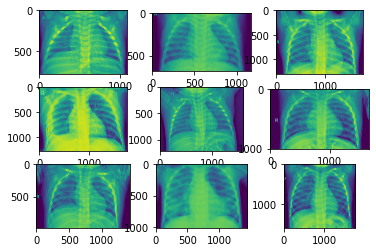

In [ ]:
# plot photos from the UC Merced dataset
from matplotlib import pyplot
from matplotlib.image import imread

nomal_filepath = 'data/chest_xray/train/NORMAL/'
pneumonia_filepath = 'data/chest_xray/train/PNEUMONIA/'
# plot first few images
normal_filename = os.listdir(nomal_filepath)
pneumo_filename = os.listdir(pneumonia_filepath)
for i in range(9):
  # define subplot
  pyplot.subplot(330 + 1 + i)
  # define filename
  if i%2 ==0:
    filename = os.path.join(nomal_filepath, normal_filename[i])
  else:
    filename = os.path.join(pneumonia_filepath, pneumo_filename[i])
  # load image pixels
  image = imread(filename)
  # plot raw pixel data
  pyplot.imshow(image)
# show the figure
pyplot.show()

# Generators

Vamos criar os generators, que são responsáveis por carregar as imagens na memória e realizar quaisquer transformações necessárias. Verifique a documentação oficial [neste link](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
'''
data
  ├───test
  │   ├───Normal
  │   │   ├───image1.jpg
  │   │   └───image2.jpg
  │   └───Opacity
  │       ├───image1.jpg
  │       └───image2.jpg
  ├───train
  │   ├───Normal
  │   │   ├───image1.jpg
  │   │   └───image2.jpg
  │   └───Opacity
  │       ├───image1.jpg
  │       └───image2.jpg
  └───val
      ├───Normal
      │   ├───image1.jpg
      │   └───image2.jpg
      └───Opacity
          ├───image1.jpg
          └───image2.jpg
'''
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
trdata = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,   
)
train_data = trdata.flow_from_directory(directory="./data/chest_xray/train/",target_size=(224,224))

vldata = ImageDataGenerator(rescale = 1./255)
val_data = vldata.flow_from_directory(directory="./data/chest_xray/test", target_size=(224,224))



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Download VGG19 Model

Vamos baixar o modelo VGG19 treinado no dataset ImageNet. Outros modelos podem ser observados [neste link](https://keras.io/api/applications/).

In [ ]:
# https://keras.io/api/applications/vgg/#vgg19-function
vgg19_model = tf.keras.applications.vgg19.VGG19(include_top=True, weights="imagenet")

574726144/574710816 [==============================] - 3s 0us/step


In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

# Método de Transfer Learning

Vamos utilizar o método de transfer learning para adaptar o modelo baixado para nossa tarefa de classificação.

Primeiro, vamos criar um novo modelo, do tipo sequencial. Em seguida, vamos percorrer todas as camadas do modelo VGG16 e adicionar cada camada no nosso modelo. Mas vamos deixar a última camada de fora e, para isso, definimos o limite até -1, que exclui a última camada.

In [ ]:
model = Sequential()
for layer in vgg19_model.layers[:-1]:
    model.add(layer)

Agora, vamos mudar nosso novo modelo sequencial, configurando cada camada como "non-trainable". Dessa forma, os pesos dessas camadas não serão atualizados durante o processo de treinamento do modelo.

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

Por fim, vamos adicionar uma última camada, que será responsável por fazer a classificação da imagem. Para isso, essa última camada deve conter um número de neurônios igual ao número de classes do dataset.

In [ ]:
model.add(Dense(units=len(classes), activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
from tensorflow.keras.optimizers import Adam 
opt = Adam(learning_rate=0.01)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Training

Agora, vamos iniciar o treinamento do nosso modelo. Lembre-se que, da forma como configuramos as camadas, apenas a última camada será treinada.

In [ ]:
#Defining the parameters
epochs=10

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs = epochs)

Epoch 1/10
163/163 [==============================] - 118s 663ms/step - loss: 0.4876 - accuracy: 0.8275 - val_loss: 0.8563 - val_accuracy: 0.6715
Epoch 2/10
163/163 [==============================] - 104s 640ms/step - loss: 0.3747 - accuracy: 0.8524 - val_loss: 0.7180 - val_accuracy: 0.7420
Epoch 3/10
163/163 [==============================] - 107s 656ms/step - loss: 0.2917 - accuracy: 0.8823 - val_loss: 1.0485 - val_accuracy: 0.6763
Epoch 4/10
163/163 [==============================] - 104s 637ms/step - loss: 0.2326 - accuracy: 0.8997 - val_loss: 0.7231 - val_accuracy: 0.7500
Epoch 5/10
163/163 [==============================] - 104s 636ms/step - loss: 0.3059 - accuracy: 0.8926 - val_loss: 2.2799 - val_accuracy: 0.6282
Epoch 6/10
163/163 [==============================] - 104s 640ms/step - loss: 0.3317 - accuracy: 0.8848 - val_loss: 1.4601 - val_accuracy: 0.6747
Epoch 7/10
163/163 [==============================] - 105s 643ms/step - loss: 0.2594 - accuracy: 0.9015 - val_loss: 0.5464 -

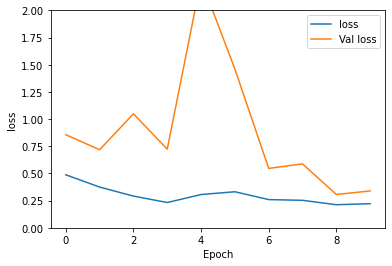

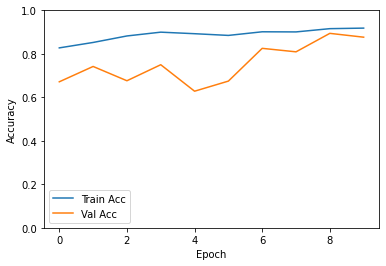

In [ ]:
from matplotlib import pyplot as plt
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    plt.ylim([0,2])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Acc')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Acc')
    plt.ylim([0,1])
    plt.legend()
    plt.show()


plot_history(history)


# Salvando o Modelo

Você pode salvar um modelo inteiro em um único. Para isso, execute o comando a seguir. Para mais informações, verifique [https://www.tensorflow.org/guide/keras/save_and_serialize](https://www.tensorflow.org/guide/keras/save_and_serialize)

In [ ]:
model.save('save_model/vgg19_x-ray_model.h5')


Para baixar o modelo para seu computador, execute o próximo comando.

In [ ]:
from google.colab import files
files.download('save_model/vgg19_x-ray_model.h5')

Salvar e baixar todo o modelo pode demorar um pouco. Talvez a melhor opção seja salvar apenas os pesos.

In [ ]:
model.save_weights("save_model/vgg19_x_ray_ckpt")


In [ ]:
!ls -lha save_model/

total 1.1G
drwxr-xr-x 2 root root 4.0K Apr  8 19:55 .
drwxr-xr-x 1 root root 4.0K Apr  8 19:53 ..
-rw-r--r-- 1 root root   89 Apr  8 19:55 checkpoint
-rw-r--r-- 1 root root 533M Apr  8 19:55 vgg19_x_ray_ckpt.data-00000-of-00001
-rw-r--r-- 1 root root 3.2K Apr  8 19:55 vgg19_x_ray_ckpt.index
-rw-r--r-- 1 root root 533M Apr  8 19:53 vgg19_x-ray_model.h5


In [ ]:
!tar -jcvf save_model_vgg19_x_ray.tar.bz save_model

In [ ]:
from google.colab import files
files.download('save_model_vgg19_x_ray.tar.bz')

# Carregando o Modelo

In [ ]:
load_status = model.load_weights("save_model/vgg19_x_ray_ckpt")
load_status

In [ ]:
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("save_model/vgg19_x-ray_model.h5")


# Testing

In [ ]:
tsdata = ImageDataGenerator()
test_data = tsdata.flow_from_directory(directory="./data/chest_xray/val", target_size=(224,224))

Found 16 images belonging to 2 classes.


In [ ]:
scores = model.evaluate(test_data)
print("Accuracy: {}".format(scores[1]))


1/1 [==============================] - 0s 230ms/step - loss: 9.6953 - accuracy: 0.6250
Accuracy: 0.625
